In [1]:
using Whirl2d

In [10]:
N = [100,100]
Δx = 0.01
xmin = [0.0,0.0]

2-element Array{Float64,1}:
 0.0
 0.0

In [11]:
g = Whirl2d.DualPatch(N,Δx,xmin)

Grid: number of cells = (100,100), Δx = 0.01, xmin = (0.0, 0.0), xmax = (1.0,1.0)


In [12]:
G = Whirl2d.Grids.lgf(g);

In [18]:
GE = Whirl2d.Grids.intfact(g,5.0);

In [15]:
w = zeros(N[1],N[2]);
w[20,20] = 1.0;
w

100×100 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [19]:
s = Whirl2d.Grids.lap_inv(w,GE);

In [21]:
round.(Whirl2d.Grids.lap(s))

LoadError: [91mUndefVarError: qx not defined[39m

In [8]:
using PyPlot

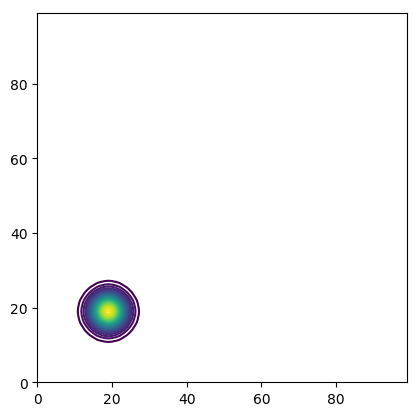

(0.0, 99.0, 0.0, 99.0)

In [20]:
contour(s,31)
axis("scaled")

In [4]:
GE = Whirl2d.Grids.intfact(g,1.0);